# Text_GCN

In [12]:
import pandas as pd
import glob

import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join

In [13]:
def load(path, pickle_file, ratio=1):
    dataset = pd.read_pickle(path + pickle_file)
    dataset.info(memory_usage='deep')
    if ratio < 1:
        dataset = get_ratio(dataset, ratio)

    return dataset

def loads(data_sets_dir, ratio=1):
    data_sets_files = sorted([f for f in listdir(data_sets_dir) if isfile(join(data_sets_dir, f))])

    if ratio < 1:
        data_sets_files = get_ratio(data_sets_files, ratio)

    dataset = load(data_sets_dir, data_sets_files[0])
    data_sets_files.remove(data_sets_files[0])

    for ds_file in data_sets_files:
        #dataset = dataset.append(load(data_sets_dir, ds_file))
        # 使用 pd.concat 来连接两个 DataFrame
        dataset = pd.concat([dataset, load(data_sets_dir, ds_file)])


    return dataset

In [14]:
import pandas as pd

def read(path, json_file):
    """
    :param path: str
    :param json_file: str
    :return DataFrame
    """
    return pd.read_json(path + json_file)

def apply_filter(data_frame: pd.DataFrame, filter_func):
    return filter_func(data_frame)

def clean(data_frame: pd.DataFrame):
    return data_frame.drop_duplicates(subset="func", keep=False)

def select(dataset):
    result = dataset.loc[dataset['project'] == "FFmpeg"]
    len_filter = result.func.str.len() < 1200
    result = result.loc[len_filter]
    #print(len(result))
    #result = result.iloc[11001:]
    #print(len(result))
    result = result.head(200)

    return result

def drop(data_frame: pd.DataFrame, keys):
    for key in keys:
        del data_frame[key]

In [15]:
raw = read("dataset/Devign/raw/", "dataset.json")

# filtered = apply_filter(raw, select)
filtered = clean(raw)
drop(filtered, ["commit_id", "project"])

In [16]:
filtered = filtered.sample(frac=1, random_state=32)
filtered = filtered.reset_index(drop=True)
filtered

,target,func
0,0,static int serial_parse(const char *devname)\n...
1,0,static void sdl_mouse_mode_change(Notifier *no...
2,1,static int openpic_init(SysBusDevice *dev)\n\n...
3,0,static inline void writer_print_string(WriterC...
4,0,static inline int32_t efsctsi(uint32_t val)\n\...
...,...,...
27193,1,static inline void RENAME(rgb16tobgr24)(const ...
27194,0,static int virtio_ccw_device_init(VirtioCcwDev...
27195,0,"int pit_get_initial_count(PITState *pit, int c..."
27196,0,static int coroutine_fn add_aio_request(BDRVSh...


In [69]:
# 添加train或者test字符串列
total_samples = len(filtered)
train_samples = int(total_samples * 5 / 6)  # 总体比例为5：1
sample_type = ['train'] * train_samples + ['test'] * (total_samples - train_samples)
filtered['type'] = sample_type

# 将数据写入txt文件
with open('data/devign.txt', 'w') as f:
    for index, row in filtered.iterrows():
        line = f"{index}\t{row['type']}\t{row['target']}\n"
        f.write(line)

In [70]:
doc_content_list = filtered["func"].tolist()
doc_content_list

['static int serial_parse(const char *devname)\n\n{\n\n    static int index = 0;\n\n    char label[32];\n\n\n\n    if (strcmp(devname, "none") == 0)\n\n        return 0;\n\n    if (index == MAX_SERIAL_PORTS) {\n\n        fprintf(stderr, "qemu: too many serial ports\\n");\n\n        exit(1);\n\n    }\n\n    snprintf(label, sizeof(label), "serial%d", index);\n\n    serial_hds[index] = qemu_chr_new(label, devname, NULL);\n\n    if (!serial_hds[index]) {\n\n        fprintf(stderr, "qemu: could not connect serial device"\n\n                " to character backend \'%s\'\\n", devname);\n\n        return -1;\n\n    }\n\n    index++;\n\n    return 0;\n\n}\n',
 'static void sdl_mouse_mode_change(Notifier *notify, void *data)\n\n{\n\n    if (kbd_mouse_is_absolute()) {\n\n        if (!absolute_enabled) {\n\n            sdl_hide_cursor();\n\n            if (gui_grab) {\n\n                sdl_grab_end();\n\n            }\n\n            absolute_enabled = 1;\n\n        }\n\n    } else if (absolute_en

In [71]:
doc_content_list[0]

'static int serial_parse(const char *devname)\n\n{\n\n    static int index = 0;\n\n    char label[32];\n\n\n\n    if (strcmp(devname, "none") == 0)\n\n        return 0;\n\n    if (index == MAX_SERIAL_PORTS) {\n\n        fprintf(stderr, "qemu: too many serial ports\\n");\n\n        exit(1);\n\n    }\n\n    snprintf(label, sizeof(label), "serial%d", index);\n\n    serial_hds[index] = qemu_chr_new(label, devname, NULL);\n\n    if (!serial_hds[index]) {\n\n        fprintf(stderr, "qemu: could not connect serial device"\n\n                " to character backend \'%s\'\\n", devname);\n\n        return -1;\n\n    }\n\n    index++;\n\n    return 0;\n\n}\n'

In [72]:
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
# from scipy.sparse.linalg.eigen.arpack import eigsh
import sys
import re


def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)


def load_data(dataset_str):
    """
    Loads input data from gcn/data directory

    ind.dataset_str.x => the feature vectors of the training instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training instances
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training instances as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test instances as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.graph => a dict in the format {index: [index_of_neighbor_nodes]} as collections.defaultdict
        object;
    ind.dataset_str.test.index => the indices of test instances in graph, for the inductive setting as list object.

    All objects above must be saved using python pickle module.

    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file(
        "data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)
    print_log(x.shape, y.shape, tx.shape, ty.shape, allx.shape, ally.shape)

    # training nodes are training docs, no initial features
    # print("x: ", x)
    # test nodes are training docs, no initial features
    # print("tx: ", tx)
    # both labeled and unlabeled training instances are training docs and words
    # print("allx: ", allx)
    # training labels are training doc labels
    # print("y: ", y)
    # test labels are test doc labels
    # print("ty: ", ty)
    # ally are labels for labels for allx, some will not have labels, i.e., all 0
    # print("ally: \n")
    # for i in ally:
    # if(sum(i) == 0):
    # print(i)
    # graph edge weight is the word co-occurence or doc word frequency
    # no need to build map, directly build csr_matrix
    # print('graph : ', graph)

    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(
            min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]
    # print(len(labels))

    idx_test = test_idx_range.tolist()
    # print(idx_test)
    idx_train = range(len(y))
    idx_val = range(len(y), len(y)+500)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask


def load_corpus(dataset_str):
    """
    Loads input corpus from gcn/data directory

    ind.dataset_str.x => the feature vectors of the training docs as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test docs as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training docs/words
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training docs as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test docs as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.adj => adjacency matrix of word/doc nodes as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.train.index => the indices of training docs in original doc list.

    All objects above must be saved using python pickle module.

    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """

    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'adj']
    objects = []
    for i in range(len(names)):
        with open("./data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, adj = tuple(objects)
    # print(x.shape, y.shape, tx.shape, ty.shape, allx.shape, ally.shape)

    features = sp.vstack((allx, tx)).tolil()
    labels = np.vstack((ally, ty))
    # print(len(labels))

    train_idx_orig = parse_index_file(
        "./data/{}.train.index".format(dataset_str))
    train_size = len(train_idx_orig)

    val_size = train_size - x.shape[0]
    test_size = tx.shape[0]

    idx_train = range(len(y))
    idx_val = range(len(y), len(y) + val_size)
    idx_test = range(allx.shape[0], allx.shape[0] + test_size)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, train_size, test_size


def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    # return sparse_to_tuple(features)
    return features.A


def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    # return sparse_to_tuple(adj_normalized)
    return adj_normalized.A


def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    """Construct feed dictionary."""
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i]
                      for i in range(len(support))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict


def chebyshev_polynomials(adj, k):
    """Calculate Chebyshev polynomials up to order k. Return a list of sparse matrices (tuple representation)."""
    print_log("Calculating Chebyshev polynomials up to order {}...".format(k))

    adj_normalized = normalize_adj(adj)
    laplacian = sp.eye(adj.shape[0]) - adj_normalized
    largest_eigval, _ = eigsh(laplacian, 1, which='LM')
    scaled_laplacian = (
        2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])

    t_k = list()
    # t_k.append(sp.eye(adj.shape[0]))
    # t_k.append(scaled_laplacian)
    t_k.append(sp.eye(adj.shape[0]).A)
    t_k.append(scaled_laplacian.A)

    def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
        s_lap = sp.csr_matrix(scaled_lap, copy=True)
        return 2 * s_lap.dot(t_k_minus_one) - t_k_minus_two

    for i in range(2, k+1):
        t_k.append(chebyshev_recurrence(t_k[-1], t_k[-2], scaled_laplacian))

    # return sparse_to_tuple(t_k)
    return t_k


def loadWord2Vec(filename):
    """Read Word Vectors"""
    vocab = []
    embd = []
    word_vector_map = {}
    file = open(filename, 'r')
    for line in file.readlines():
        row = line.strip().split(' ')
        if(len(row) > 2):
            vocab.append(row[0])
            vector = row[1:]
            length = len(vector)
            for i in range(length):
                vector[i] = float(vector[i])
            embd.append(vector)
            word_vector_map[row[0]] = vector
    print_log('Loaded Word Vectors!')
    file.close()
    return vocab, embd, word_vector_map

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


import datetime
def print_log(msg='', end='\n'):
    now = datetime.datetime.now()
    t = str(now.year) + '/' + str(now.month) + '/' + str(now.day) + ' ' \
      + str(now.hour).zfill(2) + ':' + str(now.minute).zfill(2) + ':' + str(now.second).zfill(2)

    if isinstance(msg, str):
        lines = msg.split('\n')
    else:
        lines = [msg]
        
    for line in lines:
        if line == lines[-1]:
            print('[' + t + '] ' + str(line), end=end)
        else: 
            print('[' + t + '] ' + str(line))

In [73]:
from nltk.corpus import stopwords
import nltk
from nltk.wsd import lesk
from nltk.corpus import wordnet as wn

import sys
# from utils.utils import clean_str, loadWord2Vec  


datasets = ['20ng', 'R8', 'R52', 'ohsumed', 'mr','devign']
dataset = 'devign'

word_freq = {}  # to remove rare words

for doc_content in doc_content_list:
    temp = clean_str(doc_content)
    words = temp.split()
    for word in words:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

clean_docs = []
for doc_content in doc_content_list:
    temp = clean_str(doc_content)
    words = temp.split()
    doc_words = []
    for word in words:
        # word not in stop_words and word_freq[word] >= 5
        if dataset == 'mr':
            doc_words.append(word)
        elif word not in stop_words and word_freq[word] >= 5:
            doc_words.append(word)

    doc_str = ' '.join(doc_words).strip()
    #if doc_str == '':
        #doc_str = temp
    clean_docs.append(doc_str)

clean_corpus_str = '\n'.join(clean_docs)


#with open('../data/wiki_long_abstracts_en_text.clean.txt', 'w') as f:
with open('data/corpus/' + dataset + '.clean.txt', 'w') as f:
    f.write(clean_corpus_str)

#dataset = '20ng'
min_len = 500
aver_len = 0
max_len = 0 

#with open('../data/wiki_long_abstracts_en_text.txt', 'r') as f:
with open('data/corpus/' + dataset + '.clean.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip()
        temp = line.split()
        aver_len = aver_len + len(temp)
        if len(temp) < min_len:
            min_len = len(temp)
        if len(temp) > max_len:
            max_len = len(temp)

aver_len = 1.0 * aver_len / len(lines)
print('Min_len : ' + str(min_len))
print('Max_len : ' + str(max_len))
print('Average_len : ' + str(aver_len))

Min_len : 6
Max_len : 21840
Average_len : 296.80406647547613


In [74]:
import os
import random
import numpy as np
import pickle as pkl
# import networkx as nx
import scipy.sparse as sp
from math import log
from sklearn import svm
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine


word_embeddings_dim = 300
word_vector_map = {}

# shulffing
doc_name_list = []
doc_train_list = []
doc_test_list = []

with open('data/' + dataset + '.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        doc_name_list.append(line.strip())
        temp = line.split("\t")
        if temp[1].find('test') != -1:
            doc_test_list.append(line.strip())
        elif temp[1].find('train') != -1:
            doc_train_list.append(line.strip())
# print(doc_train_list)
# print(doc_test_list)

In [75]:
doc_test_list

['22665\ttest\t0',
 '22666\ttest\t1',
 '22667\ttest\t1',
 '22668\ttest\t1',
 '22669\ttest\t0',
 '22670\ttest\t1',
 '22671\ttest\t0',
 '22672\ttest\t0',
 '22673\ttest\t1',
 '22674\ttest\t0',
 '22675\ttest\t0',
 '22676\ttest\t1',
 '22677\ttest\t0',
 '22678\ttest\t0',
 '22679\ttest\t1',
 '22680\ttest\t0',
 '22681\ttest\t1',
 '22682\ttest\t0',
 '22683\ttest\t1',
 '22684\ttest\t0',
 '22685\ttest\t1',
 '22686\ttest\t0',
 '22687\ttest\t0',
 '22688\ttest\t0',
 '22689\ttest\t0',
 '22690\ttest\t0',
 '22691\ttest\t1',
 '22692\ttest\t1',
 '22693\ttest\t0',
 '22694\ttest\t0',
 '22695\ttest\t0',
 '22696\ttest\t1',
 '22697\ttest\t1',
 '22698\ttest\t1',
 '22699\ttest\t0',
 '22700\ttest\t0',
 '22701\ttest\t0',
 '22702\ttest\t0',
 '22703\ttest\t0',
 '22704\ttest\t0',
 '22705\ttest\t1',
 '22706\ttest\t1',
 '22707\ttest\t0',
 '22708\ttest\t0',
 '22709\ttest\t1',
 '22710\ttest\t0',
 '22711\ttest\t1',
 '22712\ttest\t1',
 '22713\ttest\t0',
 '22714\ttest\t0',
 '22715\ttest\t1',
 '22716\ttest\t0',
 '22717\ttes

In [76]:
doc_content_list = []
with open('data/corpus/' + dataset + '.clean.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        doc_content_list.append(line.strip())
# print(doc_content_list)

In [77]:
train_ids = []
for train_name in doc_train_list:
    train_id = doc_name_list.index(train_name)
    train_ids.append(train_id)
# print(train_ids)
random.shuffle(train_ids)

# partial labeled data
#train_ids = train_ids[:int(0.2 * len(train_ids))]

train_ids_str = '\n'.join(str(index) for index in train_ids)
with open('data/' + dataset + '.train.index', 'w') as f:
    f.write(train_ids_str)

In [78]:
test_ids = []
for test_name in doc_test_list:
    test_id = doc_name_list.index(test_name)
    test_ids.append(test_id)
# print(test_ids)
random.shuffle(test_ids)

test_ids_str = '\n'.join(str(index) for index in test_ids)
with open('data/' + dataset + '.test.index', 'w') as f:
    f.write(test_ids_str)

In [79]:
ids = train_ids + test_ids

In [80]:
shuffle_doc_name_list = []
shuffle_doc_words_list = []
for id in ids:
    shuffle_doc_name_list.append(doc_name_list[int(id)])
    shuffle_doc_words_list.append(doc_content_list[int(id)])
shuffle_doc_name_str = '\n'.join(shuffle_doc_name_list)
shuffle_doc_words_str = '\n'.join(shuffle_doc_words_list)

with open('data/' + dataset + '_shuffle.txt', 'w') as f:
    f.write(shuffle_doc_name_str)

with open('data/corpus/' + dataset + '_shuffle.txt', 'w') as f:
    f.write(shuffle_doc_words_str)

In [81]:
# build vocab
word_freq = {}
word_set = set()
for doc_words in shuffle_doc_words_list:
    words = doc_words.split()
    for word in words:
        word_set.add(word)
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

vocab = list(word_set)
vocab_size = len(vocab)

In [82]:
word_doc_list = {}

for i in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    appeared = set()
    for word in words:
        if word in appeared:
            continue
        if word in word_doc_list:
            doc_list = word_doc_list[word]
            doc_list.append(i)
            word_doc_list[word] = doc_list
        else:
            word_doc_list[word] = [i]
        appeared.add(word)

In [83]:
word_doc_freq = {}
for word, doc_list in word_doc_list.items():
    word_doc_freq[word] = len(doc_list)

word_id_map = {}
for i in range(vocab_size):
    word_id_map[vocab[i]] = i

vocab_str = '\n'.join(vocab)

with open('data/corpus/' + dataset + '_vocab.txt', 'w') as f:
    f.write(vocab_str)

In [84]:
# label list
label_set = set()
for doc_meta in shuffle_doc_name_list:
    temp = doc_meta.split('\t')
    label_set.add(temp[2])
label_list = list(label_set)

label_list_str = '\n'.join(label_list)
with open('data/corpus/' + dataset + '_labels.txt', 'w') as f:
    f.write(label_list_str)

In [85]:
temp

['25697', 'test', '0']

In [86]:
# x: feature vectors of training docs, no initial features
# slect 90% training set
train_size = len(train_ids)
val_size = int(0.1 * train_size)
real_train_size = train_size - val_size  # - int(0.5 * train_size)
# different training rates

real_train_doc_names = shuffle_doc_name_list[:real_train_size]
real_train_doc_names_str = '\n'.join(real_train_doc_names)

with open('data/' + dataset + '.real_train.name', 'w') as f:
    f.write(real_train_doc_names_str)


row_x = []
col_x = []
data_x = []
for i in range(real_train_size):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            # print(doc_vec)
            # print(np.array(word_vector))
            doc_vec = doc_vec + np.array(word_vector)

    for j in range(word_embeddings_dim):
        row_x.append(i)
        col_x.append(j)
        # np.random.uniform(-0.25, 0.25)
        data_x.append(doc_vec[j] / doc_len)  # doc_vec[j]/ doc_len

# x = sp.csr_matrix((real_train_size, word_embeddings_dim), dtype=np.float32)
x = sp.csr_matrix((data_x, (row_x, col_x)), shape=(
    real_train_size, word_embeddings_dim))

y = []
for i in range(real_train_size):
    doc_meta = shuffle_doc_name_list[i]
    temp = doc_meta.split('\t')
    label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    y.append(one_hot)
y = np.array(y)
# print(y)

# tx: feature vectors of test docs, no initial features
test_size = len(test_ids)

row_tx = []
col_tx = []
data_tx = []
for i in range(test_size):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = shuffle_doc_words_list[i + train_size]
    words = doc_words.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            doc_vec = doc_vec + np.array(word_vector)

    for j in range(word_embeddings_dim):
        row_tx.append(i)
        col_tx.append(j)
        # np.random.uniform(-0.25, 0.25)
        data_tx.append(doc_vec[j] / doc_len)  # doc_vec[j] / doc_len

# tx = sp.csr_matrix((test_size, word_embeddings_dim), dtype=np.float32)
tx = sp.csr_matrix((data_tx, (row_tx, col_tx)),
                   shape=(test_size, word_embeddings_dim))

ty = []
for i in range(test_size):
    doc_meta = shuffle_doc_name_list[i + train_size]
    temp = doc_meta.split('\t')
    label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    ty.append(one_hot)
ty = np.array(ty)
# print(ty)

# allx: the the feature vectors of both labeled and unlabeled training instances
# (a superset of x)
# unlabeled training instances -> words

word_vectors = np.random.uniform(-0.01, 0.01,
                                 (vocab_size, word_embeddings_dim))

for i in range(len(vocab)):
    word = vocab[i]
    if word in word_vector_map:
        vector = word_vector_map[word]
        word_vectors[i] = vector

row_allx = []
col_allx = []
data_allx = []

for i in range(train_size):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            doc_vec = doc_vec + np.array(word_vector)

    for j in range(word_embeddings_dim):
        row_allx.append(int(i))
        col_allx.append(j)
        # np.random.uniform(-0.25, 0.25)
        data_allx.append(doc_vec[j] / doc_len)  # doc_vec[j]/doc_len
for i in range(vocab_size):
    for j in range(word_embeddings_dim):
        row_allx.append(int(i + train_size))
        col_allx.append(j)
        data_allx.append(word_vectors.item((i, j)))


row_allx = np.array(row_allx)
col_allx = np.array(col_allx)
data_allx = np.array(data_allx)

allx = sp.csr_matrix(
    (data_allx, (row_allx, col_allx)), shape=(train_size + vocab_size, word_embeddings_dim))

ally = []
for i in range(train_size):
    doc_meta = shuffle_doc_name_list[i]
    temp = doc_meta.split('\t')
    label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    ally.append(one_hot)

for i in range(vocab_size):
    one_hot = [0 for l in range(len(label_list))]
    ally.append(one_hot)

ally = np.array(ally)

# print(x.shape, y.shape, tx.shape, ty.shape, allx.shape, ally.shape)

'''
Doc word heterogeneous graph
'''

# word co-occurence with context windows
window_size = 20
windows = []

for doc_words in shuffle_doc_words_list:
    words = doc_words.split()
    length = len(words)
    if length <= window_size:
        windows.append(words)
    else:
        # print(length, length - window_size + 1)
        for j in range(length - window_size + 1):
            window = words[j: j + window_size]
            windows.append(window)
            # print(window)


word_window_freq = {}
for window in windows:
    appeared = set()
    for i in range(len(window)):
        if window[i] in appeared:
            continue
        if window[i] in word_window_freq:
            word_window_freq[window[i]] += 1
        else:
            word_window_freq[window[i]] = 1
        appeared.add(window[i])

word_pair_count = {}
for window in windows:
    for i in range(1, len(window)):
        for j in range(0, i):
            word_i = window[i]
            word_i_id = word_id_map[word_i]
            word_j = window[j]
            word_j_id = word_id_map[word_j]
            if word_i_id == word_j_id:
                continue
            word_pair_str = str(word_i_id) + ',' + str(word_j_id)
            if word_pair_str in word_pair_count:
                word_pair_count[word_pair_str] += 1
            else:
                word_pair_count[word_pair_str] = 1
            # two orders
            word_pair_str = str(word_j_id) + ',' + str(word_i_id)
            if word_pair_str in word_pair_count:
                word_pair_count[word_pair_str] += 1
            else:
                word_pair_count[word_pair_str] = 1

row = []
col = []
weight = []

# pmi as weights

num_window = len(windows)

for key in word_pair_count:
    temp = key.split(',')
    i = int(temp[0])
    j = int(temp[1])
    count = word_pair_count[key]
    word_freq_i = word_window_freq[vocab[i]]
    word_freq_j = word_window_freq[vocab[j]]
    pmi = log((1.0 * count / num_window) /
              (1.0 * word_freq_i * word_freq_j/(num_window * num_window)))
    if pmi <= 0:
        continue
    row.append(train_size + i)
    col.append(train_size + j)
    weight.append(pmi)

# word vector cosine similarity as weights

# doc word frequency
doc_word_freq = {}

for doc_id in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[doc_id]
    words = doc_words.split()
    for word in words:
        word_id = word_id_map[word]
        doc_word_str = str(doc_id) + ',' + str(word_id)
        if doc_word_str in doc_word_freq:
            doc_word_freq[doc_word_str] += 1
        else:
            doc_word_freq[doc_word_str] = 1

for i in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_word_set = set()
    for word in words:
        if word in doc_word_set:
            continue
        j = word_id_map[word]
        key = str(i) + ',' + str(j)
        freq = doc_word_freq[key]
        if i < train_size:
            row.append(i)
        else:
            row.append(i + vocab_size)
        col.append(train_size + j)
        idf = log(1.0 * len(shuffle_doc_words_list) /
                  word_doc_freq[vocab[j]])
        weight.append(freq * idf)
        doc_word_set.add(word)

node_size = train_size + vocab_size + test_size
adj = sp.csr_matrix(
    (weight, (row, col)), shape=(node_size, node_size))

# dump objects
with open("data/ind.{}.x".format(dataset), 'wb') as f:
    pkl.dump(x, f)

with open("data/ind.{}.y".format(dataset), 'wb') as f:
    pkl.dump(y, f)

with open("data/ind.{}.tx".format(dataset), 'wb') as f:
    pkl.dump(tx, f)

with open("data/ind.{}.ty".format(dataset), 'wb') as f:
    pkl.dump(ty, f)

with open("data/ind.{}.allx".format(dataset), 'wb') as f:
    pkl.dump(allx, f)

with open("data/ind.{}.ally".format(dataset), 'wb') as f:
    pkl.dump(ally, f)

with open("data/ind.{}.adj".format(dataset), 'wb') as f:
    pkl.dump(adj, f)

In [87]:
import torch
import torch.nn as nn


class GraphConvolution(nn.Module):
    def __init__( self, input_dim, \
                        output_dim, \
                        support, \
                        act_func = None, \
                        featureless = False, \
                        dropout_rate = 0., \
                        bias=False):
        super(GraphConvolution, self).__init__()
        self.support = support
        self.featureless = featureless

        for i in range(len(self.support)):
            setattr(self, 'W{}'.format(i), nn.Parameter(torch.randn(input_dim, output_dim)))

        if bias:
            self.b = nn.Parameter(torch.zeros(1, output_dim))

        self.act_func = act_func
        self.dropout = nn.Dropout(dropout_rate)

        
    def forward(self, x):
        x = self.dropout(x)

        for i in range(len(self.support)):
            if self.featureless:
                pre_sup = getattr(self, 'W{}'.format(i))
            else:
                pre_sup = x.mm(getattr(self, 'W{}'.format(i)))
            
            if i == 0:
                out = self.support[i].mm(pre_sup)
            else:
                out += self.support[i].mm(pre_sup)

        if self.act_func is not None:
            out = self.act_func(out)

        self.embedding = out
        return out


class GCN(nn.Module):
    def __init__( self, input_dim, \
                        support,\
                        dropout_rate=0., \
                        num_classes=10):
        super(GCN, self).__init__()
        
        # GraphConvolution
        self.layer1 = GraphConvolution(input_dim, 200, support, act_func=nn.ReLU(), featureless=True, dropout_rate=dropout_rate)
        self.layer2 = GraphConvolution(200, num_classes, support, dropout_rate=dropout_rate)
        
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

In [88]:
#!/usr/bin/env python
import torch
import torch.nn as nn


class MLP(nn.Module):
    def __init__(self, input_dim, dropout_rate=0., num_classes=10):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_dim, 200)
        self.fc2 = nn.Linear(200, num_classes)
        
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)

        return out

In [92]:
class CONFIG(object):
    """docstring for CONFIG"""
    def __init__(self):
        super(CONFIG, self).__init__()
        
        self.dataset = 'devign'
        self.model = 'gcn'  # 'gcn', 'gcn_cheby', 'dense'
        self.learning_rate = 0.02   # Initial learning rate.
        self.epochs  = 100  # Number of epochs to train.
        self.hidden1 = 200  # Number of units in hidden layer 1.
        self.dropout = 0.5  # Dropout rate (1 - keep probability).
        self.weight_decay = 0.   # Weight for L2 loss on embedding matrix.
        self.early_stopping = 10 # Tolerance for early stopping (# of epochs).
        self.max_degree = 3      # Maximum Chebyshev polynomial degree.

In [93]:
from __future__ import division
from __future__ import print_function
from sklearn import metrics
import random
import time
import os
import torch.nn as nn
import numpy as np
cfg = CONFIG()

In [94]:
cfg.dataset = dataset

In [97]:
# Set random seed
seed = random.randint(1, 200)
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

np.bool = np.bool_

# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, train_size, test_size = load_corpus(
    cfg.dataset)

features = sp.identity(features.shape[0])  # featureless

In [99]:
# Some preprocessing
features = preprocess_features(features)
if cfg.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif cfg.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, cfg.max_degree)
    num_supports = 1 + cfg.max_degree
    model_func = GCN
elif cfg.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(cfg.model))


In [100]:
# Define placeholders
t_features = torch.from_numpy(features)
t_y_train = torch.from_numpy(y_train)
t_y_val = torch.from_numpy(y_val)
t_y_test = torch.from_numpy(y_test)
t_train_mask = torch.from_numpy(train_mask.astype(np.float32))
tm_train_mask = torch.transpose(torch.unsqueeze(t_train_mask, 0), 1, 0).repeat(1, y_train.shape[1])

t_support = []
for i in range(len(support)):
    t_support.append(torch.Tensor(support[i]))


In [101]:
model = model_func(input_dim=features.shape[0], support=t_support, num_classes=y_train.shape[1])

In [102]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate)

In [103]:
# Define model evaluation function
def evaluate(features, labels, mask):
    t_test = time.time()
    # feed_dict_val = construct_feed_dict(
    #     features, support, labels, mask, placeholders)
    # outs_val = sess.run([model.loss, model.accuracy, model.pred, model.labels], feed_dict=feed_dict_val)
    model.eval()
    with torch.no_grad():
        logits = model(features)
        t_mask = torch.from_numpy(np.array(mask*1., dtype=np.float32))
        tm_mask = torch.transpose(torch.unsqueeze(t_mask, 0), 1, 0).repeat(1, labels.shape[1])
        loss = criterion(logits * tm_mask, torch.max(labels, 1)[1])
        pred = torch.max(logits, 1)[1]
        acc = ((pred == torch.max(labels, 1)[1]).float() * t_mask).sum().item() / t_mask.sum().item()
        
    return loss.numpy(), acc, pred.numpy(), labels.numpy(), (time.time() - t_test)

val_losses = []

In [104]:
# Train model
for epoch in range(cfg.epochs):

    t = time.time()
    
    # Forward pass
    logits = model(t_features)
    loss = criterion(logits * tm_train_mask, torch.max(t_y_train, 1)[1])    
    acc = ((torch.max(logits, 1)[1] == torch.max(t_y_train, 1)[1]).float() * t_train_mask).sum().item() / t_train_mask.sum().item()
        
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    val_loss, val_acc, pred, labels, duration = evaluate(t_features, t_y_val, val_mask)
    val_losses.append(val_loss)

    print_log("Epoch: {:.0f}, train_loss= {:.5f}, train_acc= {:.5f}, val_loss= {:.5f}, val_acc= {:.5f}, time= {:.5f}"\
                .format(epoch + 1, loss, acc, val_loss, val_acc, time.time() - t))

    if epoch > cfg.early_stopping and val_losses[-1] > np.mean(val_losses[-(cfg.early_stopping+1):-1]):
        print_log("Early stopping...")
        break


print_log("Optimization Finished!")

[2024/3/3 15:53:13] Epoch: 1, train_loss= 0.71415, train_acc= 0.53792, val_loss= 0.70266, val_acc= 0.46823, time= 35.15554
[2024/3/3 15:53:49] Epoch: 2, train_loss= 0.77520, train_acc= 0.47125, val_loss= 0.69454, val_acc= 0.52295, time= 35.41389
[2024/3/3 15:54:18] Epoch: 3, train_loss= 0.69870, train_acc= 0.53571, val_loss= 0.69346, val_acc= 0.57414, time= 29.68544
[2024/3/3 15:54:45] Epoch: 4, train_loss= 0.68516, train_acc= 0.59223, val_loss= 0.69574, val_acc= 0.56708, time= 27.00281
[2024/3/3 15:55:12] Epoch: 5, train_loss= 0.70141, train_acc= 0.57606, val_loss= 0.69500, val_acc= 0.57237, time= 26.19579
[2024/3/3 15:55:39] Epoch: 6, train_loss= 0.69079, train_acc= 0.59101, val_loss= 0.69318, val_acc= 0.59400, time= 27.80354
[2024/3/3 15:56:07] Epoch: 7, train_loss= 0.67099, train_acc= 0.62954, val_loss= 0.69226, val_acc= 0.62224, time= 27.49338
[2024/3/3 15:56:35] Epoch: 8, train_loss= 0.65972, train_acc= 0.67175, val_loss= 0.69254, val_acc= 0.60944, time= 28.19979
[2024/3/3 15:57:

In [105]:
# Testing
test_loss, test_acc, pred, labels, test_duration = evaluate(t_features, t_y_test, test_mask)
print_log("Test set results: \n\t loss= {:.5f}, accuracy= {:.5f}, time= {:.5f}".format(test_loss, test_acc, test_duration))

test_pred = []
test_labels = []
for i in range(len(test_mask)):
    if test_mask[i]:
        test_pred.append(pred[i])
        test_labels.append(np.argmax(labels[i]))


print_log("Test Precision, Recall and F1-Score...")
print_log(metrics.classification_report(test_labels, test_pred, digits=4))
print_log("Macro average Test Precision, Recall and F1-Score...")
print_log(metrics.precision_recall_fscore_support(test_labels, test_pred, average='macro'))
print_log("Micro average Test Precision, Recall and F1-Score...")
print_log(metrics.precision_recall_fscore_support(test_labels, test_pred, average='micro'))

# doc and word embeddings
tmp = model.layer1.embedding.numpy()
word_embeddings = tmp[train_size: adj.shape[0] - test_size]
train_doc_embeddings = tmp[:train_size]  # include val docs
test_doc_embeddings = tmp[adj.shape[0] - test_size:]

print_log('Embeddings:')
print_log('\rWord_embeddings:'+str(len(word_embeddings)))
print_log('\rTrain_doc_embeddings:'+str(len(train_doc_embeddings))) 
print_log('\rTest_doc_embeddings:'+str(len(test_doc_embeddings))) 
print_log('\rWord_embeddings:') 
print(word_embeddings)


[2024/3/3 16:02:15] Test set results: 
[2024/3/3 16:02:15] 	 loss= 0.69341, accuracy= 0.60468, time= 7.96003
[2024/3/3 16:02:15] Test Precision, Recall and F1-Score...
[2024/3/3 16:02:15]               precision    recall  f1-score   support
[2024/3/3 16:02:15] 
[2024/3/3 16:02:15]            0     0.6000    0.8111    0.6898      2456
[2024/3/3 16:02:15]            1     0.6175    0.3606    0.4553      2077
[2024/3/3 16:02:15] 
[2024/3/3 16:02:15]     accuracy                         0.6047      4533
[2024/3/3 16:02:15]    macro avg     0.6087    0.5858    0.5725      4533
[2024/3/3 16:02:15] weighted avg     0.6080    0.6047    0.5823      4533
[2024/3/3 16:02:15] 
[2024/3/3 16:02:15] Macro average Test Precision, Recall and F1-Score...
[2024/3/3 16:02:15] (0.6087386644682605, 0.585845596019064, 0.5725349207284729, None)
[2024/3/3 16:02:15] Micro average Test Precision, Recall and F1-Score...
[2024/3/3 16:02:15] (0.6046768144716523, 0.6046768144716523, 0.6046768144716523, None)
[2024/

In [106]:
with open('data/corpus/' + dataset + '_vocab.txt', 'r') as f:
    words = f.readlines()

vocab_size = len(words)
word_vectors = []
for i in range(vocab_size):
    word = words[i].strip()
    word_vector = word_embeddings[i]
    word_vector_str = ' '.join([str(x) for x in word_vector])
    word_vectors.append(word + ' ' + word_vector_str)

word_embeddings_str = '\n'.join(word_vectors)
with open('data/' + dataset + '_word_vectors.txt', 'w') as f:
    f.write(word_embeddings_str)



doc_vectors = []
doc_id = 0
for i in range(train_size):
    doc_vector = train_doc_embeddings[i]
    doc_vector_str = ' '.join([str(x) for x in doc_vector])
    doc_vectors.append('doc_' + str(doc_id) + ' ' + doc_vector_str)
    doc_id += 1

for i in range(test_size):
    doc_vector = test_doc_embeddings[i]
    doc_vector_str = ' '.join([str(x) for x in doc_vector])
    doc_vectors.append('doc_' + str(doc_id) + ' ' + doc_vector_str)
    doc_id += 1

doc_embeddings_str = '\n'.join(doc_vectors)
with open('data/' + dataset + '_doc_vectors.txt', 'w') as f:
    f.write(doc_embeddings_str)

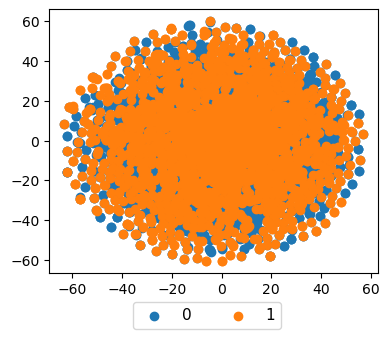

In [112]:
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import numpy as np
import os


data_set = 'devign' # 20ng R8 R52 ohsumed mr
data_path = 'data'


f = open(os.path.join(data_path, data_set + '.train.index'), 'r')
lines = f.readlines()
f.close()
train_size = len(lines)


f = open(os.path.join(data_path, data_set + '_shuffle.txt'), 'r')
lines = f.readlines()
f.close()

target_names = set()
labels = []
for line in lines:
    line = line.strip()
    temp = line.split('\t')
    labels.append(temp[2])
    target_names.add(temp[2])

target_names = list(target_names)

f = open(os.path.join(data_path, data_set + '_doc_vectors.txt'), 'r')
lines = f.readlines()
f.close()

docs = []
for line in lines:
    temp = line.strip().split()
    values_str_list = temp[1:]
    values = [float(x) for x in values_str_list]
    docs.append(values)

fea = docs[train_size:]  # int(train_size * 0.9)
label = labels[train_size:]  # int(train_size * 0.9)
label = np.array(label)

fea = np.array(fea)
fea = TSNE(n_components=2).fit_transform(fea)
pdf = PdfPages(data_set + '_gcn_doc_test.pdf')
cls = np.unique(label)

plt.figure(figsize=(4, 3.5))  # 设置图像大小

# cls=range(10)
fea_num = [fea[label == i] for i in cls]
for i, f in enumerate(fea_num):
    if cls[i] in range(10):
        plt.scatter(f[:, 0], f[:, 1], label=cls[i], marker='+')
    else:
        plt.scatter(f[:, 0], f[:, 1], label=cls[i])
plt.legend(ncol=5, loc='upper center', bbox_to_anchor=(0.48, -0.08), fontsize=11)
# plt.ylim([-20,35])
# plt.title(md_file)
plt.tight_layout()
pdf.savefig()
plt.show()
pdf.close()